# Natural Computing - Project - Data Preprocessing 
#### Group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

## Imports

In [1]:
# Data processing and plotting
from tensorflow.keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt

# Standard python imports
import numpy as np
import pickle, os, cv2

# Magic for inline plots
%matplotlib inline

## Global parameters

In [47]:
# Dataset parameters
DATASET = "Fashion-MNIST" # choose from {"MNIST", "Fashion-MNIST"}
DESIRED_IMAGE_SIZE = (16, 16)
N_CLASSES_TO_USE = 10

## Preprocessing data

##### Downloading the correct dataset

In [48]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() if DATASET == "MNIST" else fashion_mnist.load_data()

##### Removing classes

In [49]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

In [50]:
# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 60000
Testing samples remaining: 10000


##### Rescaling, unskewing & resizing

In [51]:
# This preprocessing procedure is heavily based on the one used in WANN:
# https://github.com/google/brain-tokyo-workshop/blob/master/WANNRelease/WANN/domain/classify_gym.py

def preprocess(samples, size, n_samples, unskew=True):
    # Create list of processed images
    processed  = np.empty((n_samples,size[0],size[1]))

    # Unskew and resize
    if unskew == True:    
        for i in range(n_samples):
            processed[i,:,:] = deskew(cv2.resize(samples[i,:,:],size),size)
    return processed

def deskew(image, image_shape, negated=True):
    """ source: https://github.com/vsvinayak/mnist-helper """
  
    # negate the image
    if not negated:
        image = 255-image
    
    # calculate the moments of the image
    m = cv2.moments(image)
    if abs(m['mu02']) < 1e-2:
        return image.copy()
    
    # caclulating the skew
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*image_shape[0]*skew], [0,1,0]])
    img = cv2.warpAffine(image, M, image_shape, flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)  
    return img

In [52]:
# Rescale and preprocess training and testing data
X_train_processed = preprocess(X_train/255, DESIRED_IMAGE_SIZE, n_samples_train)
X_test_processed = preprocess(X_test/255, DESIRED_IMAGE_SIZE, n_samples_test)

##### Plotting an example

In [53]:
# Function for plotting an image before and after processing, side-by-side
def plot_comparison(idx_to_plot, datasets, titles):
    n_plots = len(datasets)
    fig, ax = plt.subplots(1,n_plots, figsize=(8,4))
    for i in range(n_plots):
        ax[i].imshow(datasets[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    #fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.savefig('preprocessing_fashion.jpg')
    plt.show()

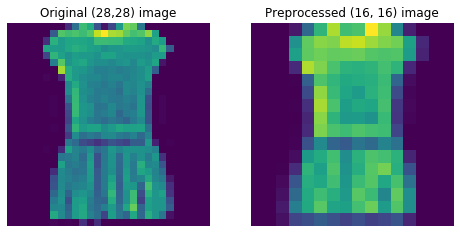

In [54]:
# Plot an example image
idx_to_plot = 3
datasets = [X_train, X_train_processed]
titles = [f"Original ({X_train.shape[1]},{X_train.shape[1]}) image",
          f"Preprocessed {DESIRED_IMAGE_SIZE} image"]
plot_comparison(idx_to_plot, datasets, titles)

##### Wrapping up

In [10]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_processed.reshape(n_samples_train, np.prod(DESIRED_IMAGE_SIZE))
X_test = X_test_processed.reshape(n_samples_test, np.prod(DESIRED_IMAGE_SIZE))

In [11]:
# Check if data folder exists; if not, create it
if not os.path.exists("data"):
    os.mkdir("data")
    
# Set the correct filename
filename = f"{DATASET}-{N_CLASSES_TO_USE}.pkl"

# Store the preprocessed data
with open(os.path.join("data", filename), "wb") as f:
    pickle.dump(((X_train, Y_train), (X_test, Y_test)), f)